<a href="https://colab.research.google.com/github/Muniz97/Data-Science---Federal-road-accidents---Brazil/blob/main/4%20-%20Model/Federal_Accidents_Model_Vers%C3%A3o_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier


from sklearn.model_selection import validation_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics  import accuracy_score, precision_score, recall_score ,f1_score, confusion_matrix, roc_curve, auc,roc_auc_score,precision_recall_curve;

from tabulate import tabulate

# Coleta de Base

Como visto no passo anterior, geramos duas bases de treino uma com dados originais e outra com dados sinteticos (oversampling), e por fim uma base de teste, na qual usaremos para avaliar os modelos.

In [2]:
# Permite que todas as colunas do dataframe sejam apresentadas
pd.set_option('display.max_columns', None)

# Busca as bases de treino e teste
df_train_smote = pd.read_csv('/content/drive/MyDrive/Bases Projetos/2 - Acidentes rodoviária federal - Brasil/train_smote.csv')
df_train = pd.read_csv('https://raw.githubusercontent.com/Muniz97/Federal-road-accidents---Brazil/main/3%20-%20Preprocessing/train_encoder.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/Muniz97/Federal-road-accidents---Brazil/main/3%20-%20Preprocessing/test_encoder.csv')

**Obs**: Devido ao tamanho do arquivo de treino com oversampling ele ficará disponivel via Google Drive, pode ser acessado via [link](https://drive.google.com/file/d/1e752rs0m0TtbauWc9HEw57Bwd5BSPHYV/view?usp=sharing) ou replicando o passo a passo que realizei neste projeto.

Agora vamos separar as bases!

In [3]:
# Base de treino original
x_train = df_train.drop(['obitos'], axis = 1)
y_train = df_train['obitos']

# Base de teste
x_test = df_test.drop(['obitos'], axis = 1)
y_test = df_test['obitos']

Revisando a distribuição da Target:

In [4]:
print('Base de treino')
print(f'Número de observações: {x_train.shape[0]}')
print(f'Número de variaveis: {x_train.shape[1]}')
print('')
print('Distribuição da variável resposta/target')
print(f'Acidentes sem vitimas fatais (não evento): {y_train.value_counts()[0]}')
print(f'Acidentes com vitimas fatais (evento): {y_train.value_counts()[1]}')

Base de treino
Número de observações: 147640
Número de variaveis: 25

Distribuição da variável resposta/target
Acidentes sem vitimas fatais (não evento): 136974
Acidentes com vitimas fatais (evento): 10666


# Select Features

Esta sessão é dedicada a fazer a seleção das features. Objetivo é escolher as variáveis que melhoram o resultado dos modelos.

Realizarei dois tipos de separação **Seleção com Base na Correlação** e **SelectKBest**, com isso deixaremos a etapa mais robusta e adotando uma especie de "triagem" para identificar as melhores variáveis.

## Seleção com Base na Correlação

Agora que as variáveis categóricas já foram **padronizadas** e podem ser utilizadas como valores numéricos pelos modelos, isso gera um ponto de atenção, mesmo que originalmente sejam classes; agora, elas podem possuir correlação entre si.

Isso significa que pode existir **correlação** baixa, alta e ausência, como vimos anteriormente. Portanto, tal comportamento pode gerar viés no modelo, fazendo com que ele tenha uma tendência em estimar determinado valor ou evento, assim gerando suposições bastante simplificadas. Um fenômeno comum é a multicolinearidade.

**Multicolinearidade** é um fenômeno no qual as features possuem alta correlação entre si; isso faz com que o algoritmo tenha dificuldade de reconhecer o comportamento individual das variáveis.


Utilizaremos a **Correlação de Spearman**, que, como visto anteriormente, estamos lidando com dados não distribuídos normalmente, e tal medida é menos sensível a outliers.

Para evitar

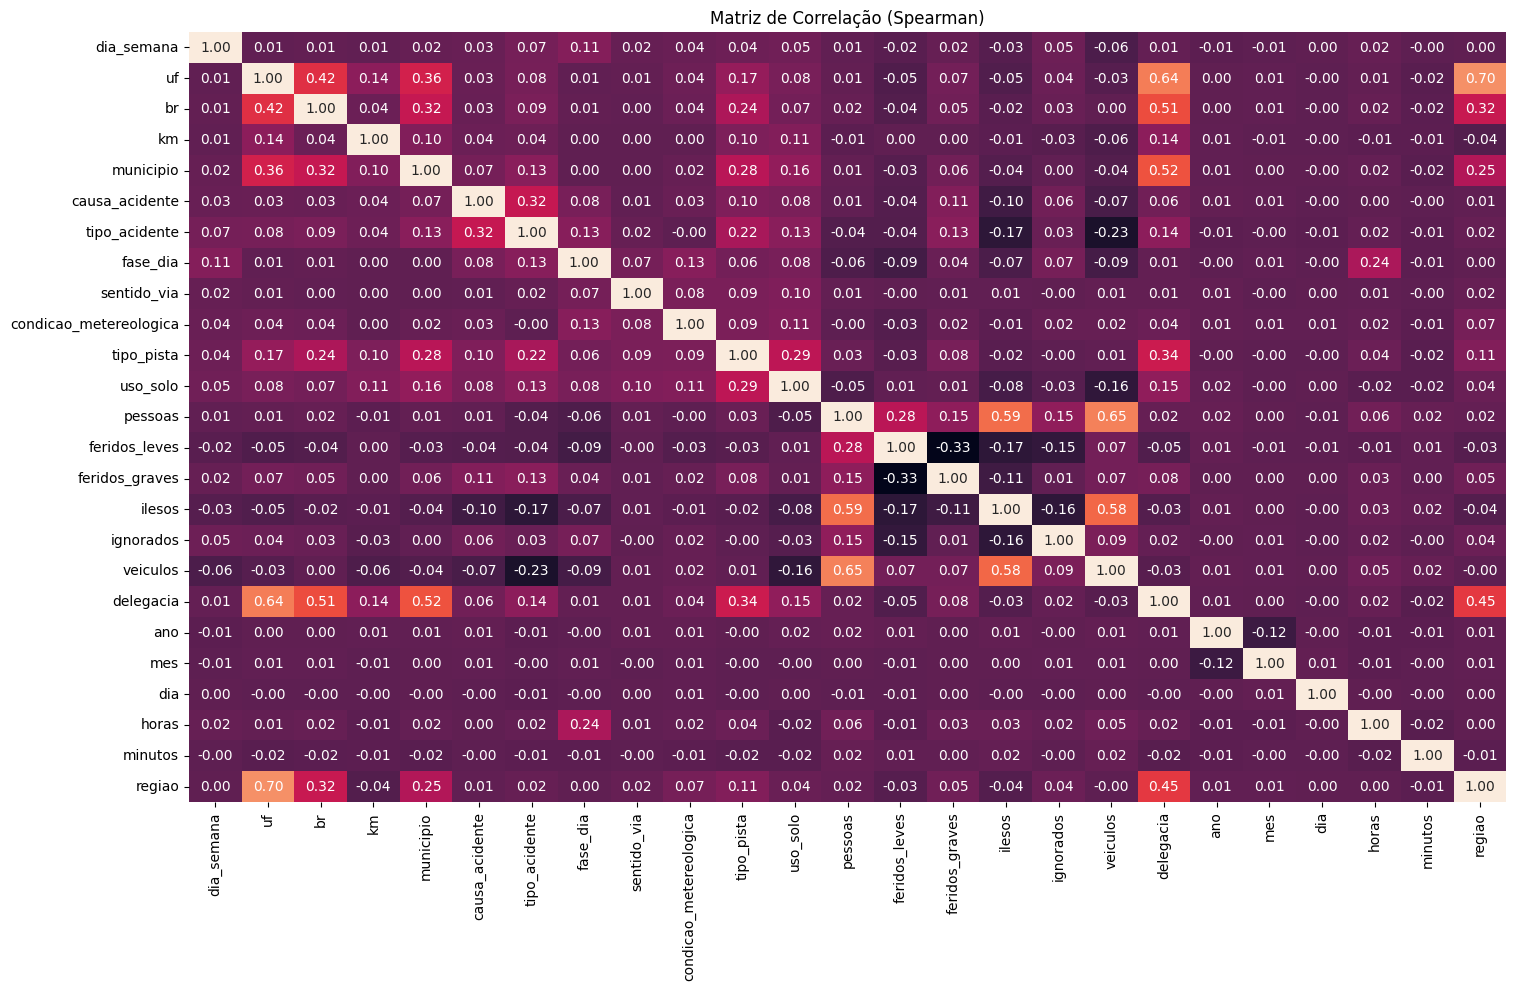

In [5]:
# Correlação por Spearman
matriz = x_train.corr(method = 'spearman')
plt.figure(figsize = (17,10))
sns.heatmap(matriz, annot = True, fmt = '.2f' , cbar = False)
plt.title('Matriz de Correlação (Spearman)')
plt.show()

Para fazer a seleção por correlação, adotarei duas regras para remoção:

1.    Features com correlação igual ou superior a 0.7;
2.    Features com 3 ou mais correlações acima de 0.5.

Como visto pela Matriz de Correlação, as features que se encaixam na filtragem são "uf" e "delegacia".

Obs: A feature "pessoas" é a soma de todas as outras que contabilizam a participação de indivíduos nos acidentes; logo, é ambígua. Portanto, também será removida.

In [6]:
# Remoção das colunas para treino e teste
x_train.drop(['uf','delegacia','pessoas'], axis = 1, inplace= True)
x_test.drop(['uf','delegacia','pessoas'], axis = 1, inplace= True)

## SelectKBest

SelectKBest" é um algoritmo para selecionar features, no qual realiza uma análise de cada uma com à target, em seguida atribui uma pontuação conforme determinada métrica pré-estabelecida e mantém "K" número de variáveis que tiveram o melhor score.

Para o projeto utilizarei a métrica **f_classif**, conhecida para modelos de classifição e que usa ANOVA(Análise de Variância) para medir a pontuação, pois ela sugere o quanto as médias das variáveis ajudam a distinguir entre as diferentes classes.

Como estamos trabalhando com 21 variáveis, pois adotei CatBoostEncoder aos invés de One-Hot ou Get Dummies que gerariam mais colunas. Vou ser mais contido e manterei 2/3 das features.


**Obs**: Não utilizei a métrica chi2(qui-quadro), que também é muito comum em modelos de classificação, pois ela não permite valores negativos, dos quais possuem nos datasets.


In [7]:
# Aplicando o SelectKBest e seus parametros
k_best = SelectKBest(f_classif, k = 14)
k_best.fit(x_train, y_train)

x_train_kbest = k_best.transform(x_train)
x_test_kbest = k_best.transform(x_test)

Agora que a técnica foi aplicada, vamos observar quais as features foram mantidas e descartadas.

In [8]:
# Features escolhidas pelo SelectKBest
df_selected_features = pd.DataFrame({'Feature': x_train.columns, 'SelectKBest': k_best.get_support()})
print(df_selected_features)

                   Feature  SelectKBest
0               dia_semana         True
1                       br         True
2                       km         True
3                municipio         True
4           causa_acidente         True
5            tipo_acidente         True
6                 fase_dia         True
7              sentido_via        False
8   condicao_metereologica        False
9               tipo_pista         True
10                uso_solo         True
11           feridos_leves         True
12          feridos_graves         True
13                  ilesos        False
14               ignorados         True
15                veiculos         True
16                     ano        False
17                     mes        False
18                     dia        False
19                   horas        False
20                 minutos        False
21                  regiao         True


# Modelos

Nesta sessão irei criar modelos de classificação para estimar a probabilidade de tem vitímas fatais para acidentes em rodovias federais, logo, será considerado evento.

Agora que as variáveis estão tratadas e já selecionamos as melhores features, os modelos serão criados com a seguinte proposta:

**Machine Learning**:

> 1.   Regressão Logística;
> 2.   Método baseado na distância;
> 3.   Árvores de Decisão;
> 4.   Árvores de Decisão Boost (sequencial).

**Avaliação de modelos**: Para availiação dos modelos utilizarei em conjunto F1-Score e ROC AUC. O modelo que tiver os dois melhores indicadores será escolhido.






**Obs**: Não utilizarei AutoML e GridSearchCV neste projeto, pois quero explorar estes 4 modelos especificamente.

## Regressão Logistica

In [9]:
# Criando o modelo LogisticRegression
model_log = LogisticRegression(random_state= 1337, max_iter = 250) # penalty='l1')
model_log.fit(x_train_kbest,y_train)
log_predict = model_log.predict(x_test_kbest)

Não realizei mudanças, pois o Logistic Regression servirá como **baseline**, que é mais robusto que o Dummy Classifier.

## K-Nearest Neighbors (KNN)

### Curva de Validação

A Curva de Validação é uma técnica utilizada para identificar qual o valor de um parametro atinge o melhor resultado pré definido.


Nesse caso, o modelo de KNN define como padrão 5 o número de vizinhos que será utilizado para realizar a classificação, logo surge a pergunta: "Qual o melhor número de vizinhos ?". Então é realizei um "***loop***" que executa o algoritmo, trocando esse parametro e demostre gráficamente qual o valor que gere o melhor resultado de **F1-Score**.

In [10]:
# Cria o Range
range = np.arange(1, 5) # 5 Valores

# Cria modelo base apenas com a metrica
model_knn = KNeighborsClassifier(metric = 'minkowski')

# Curva de Validação
train_scores, test_scores = validation_curve(
    model_knn, x_train, y_train, param_name="n_neighbors", param_range=range,
    cv=5, scoring="f1", n_jobs=-1)

# Média do resultado
train_scores = np.mean(train_scores, axis=1)
test_scores = np.mean(test_scores, axis=1)

**Minkowski** é uma metrica de distancia generalizada das distancias Euclidiana e Manhattan. Utilizarei, pois ela é flexível e pode se adpatar a depender do problema.

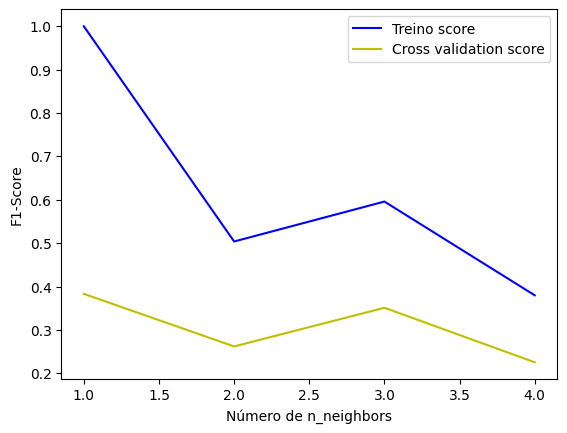

In [11]:
plt.plot(range, train_scores, label="Treino score", color="b")
plt.plot(range, test_scores, label="Cross validation score", color="y")
plt.xlabel("Número de n_neighbors")
plt.ylabel("F1-Score")
plt.legend(loc="best")
plt.show()

Conforme demostrado no gráfico, o número de número de vizinhos que aumenta o indicador de F1-Score é 3 n_neighbors.

In [12]:
# Criação do K-Nearest Neighbors
model_knn = KNeighborsClassifier(metric = 'minkowski',  n_neighbors = 3)
model_knn.fit(x_train_kbest, y_train)
knn_predict = model_knn.predict(x_test_kbest)

## Random Forest

In [13]:
# Criação do Random Forest
model_random = RandomForestClassifier(n_estimators= 150, random_state = 1337, criterion= 'gini')
model_random.fit(x_train_kbest,y_train)
random_predict = model_random.predict(x_test_kbest)

Ampliei o número de estimadores para 150, o padrão é 100, a ideia é ter mais estimadores devido ao desbalanceamento geral da amostra.

Agora vamos ver quais as variaveis **mais importantes** para o modelo.

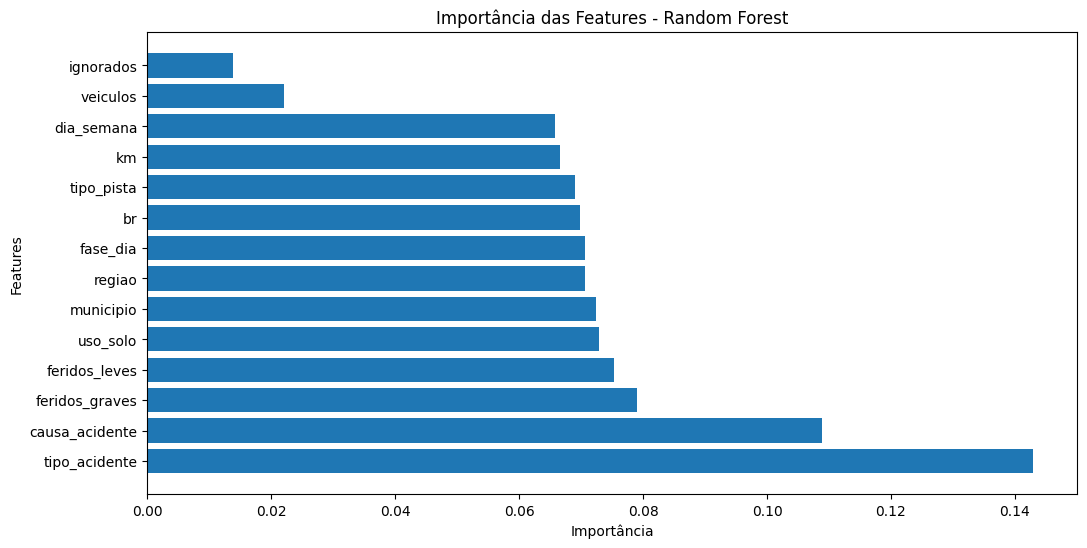

In [14]:
# Nome de todas as features
original_feature_names = ['dia_semana', 'br', 'km', 'municipio', 'causa_acidente','tipo_acidente', 'fase_dia', 'sentido_via', 'condicao_metereologica','tipo_pista', 'uso_solo', 'feridos_leves', 'feridos_graves', 'ilesos','ignorados', 'veiculos', 'ano', 'mes', 'dia', 'horas', 'minutos','regiao']
selected_feature_indices = k_best.get_support(indices=True)

# Verifica das features originais quais foram selecionadas pelo Selekbest (similar ao gerado anteriormente)
selected_feature_names = [original_feature_names[i] for i in selected_feature_indices]

# Features + importantes
feature_importances = model_random.feature_importances_

# Ordenado por importância
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_names = [selected_feature_names[i] for i in sorted_indices]
sorted_importances = [feature_importances[i] for i in sorted_indices]

plt.figure(figsize=(12, 6))
plt.barh(sorted_feature_names, sorted_importances)
plt.title('Importância das Features - Random Forest')
plt.xlabel('Importância')
plt.ylabel('Features')
plt.show()

## Gradient Boosting Classifier

In [15]:
# Criando o modelo GradientBoostingClassifier
model_gb = GradientBoostingClassifier(n_estimators = 75 , random_state = 1337, max_depth = 8, learning_rate = 0.1)
model_gb.fit(x_train_kbest, y_train)
gb_predict= model_gb.predict(x_test_kbest)

Como a base é desbalanceada, coloquei n_estimators = 75 e max_depth = 8 para estimular mais a sequencia do algoritmo e assim buscar a melhor predição, dado a distribuição. Exagerar mais nesses hiperparâmetros podem gerar overfitting.

As features mais importantes do Gradient Boosting

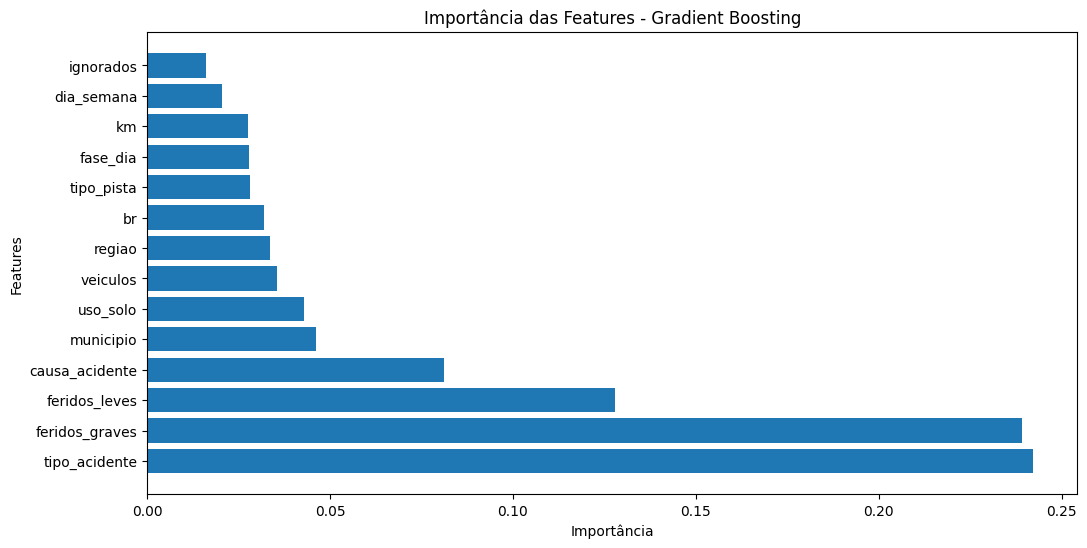

In [16]:
# Importância das features
feature_importances_gb = model_gb.feature_importances_
sorted_indices_gb = np.argsort(feature_importances_gb)[::-1]

# Ordem
sorted_feature_names_gb = [selected_feature_names[i] for i in sorted_indices_gb]
sorted_importances_gb = [feature_importances_gb[i] for i in sorted_indices_gb]

# Plot
plt.figure(figsize=(12, 6))
plt.barh(sorted_feature_names_gb, sorted_importances_gb)
plt.title('Importância das Features - Gradient Boosting')
plt.xlabel('Importância')
plt.ylabel('Features')
plt.show()

## Validação Cruzada

É uma das muitas técnicas de análise de modelos, onde a base de treino é dividida em "K" conjuntos de treino e teste.

Dado isso, os objetivos são:

1.    Identificar dentre os modelos criados quais possuem o melhor desempenho conforme a mudança de amostras no treinamento.
2.    Indicar capacidade de generalização.
3.    Comparar modelos.

Por padrão, o algoritmo faz a "scoragem" com acurácia, mas neste caso, utilizarei F1-Score, que é um dos indicadores escolhidos para avaliação de modelos neste estudo (o outro é ROC AUC).

In [17]:
# Cross-Validation
f1_model_1 = cross_val_score(model_log, x_train_kbest, y_train, cv=5, scoring='f1')
f1_model_2 = cross_val_score(model_knn, x_train_kbest, y_train, cv=5, scoring='f1')
f1_model_3 = cross_val_score(model_random, x_train_kbest, y_train, cv=5, scoring='f1')
f1_model_4 = cross_val_score(model_gb, x_train_kbest, y_train, cv=5, scoring='f1')

Agora vamos verificar o valores de **média** e **desvio padrão** dos resultados da Validação Cruzada.

In [18]:
print(f'F1-Score médio para modelo de Regressão: {f1_model_1.mean():.2f}')
print(f'Desvio padrão do F1-Score para modelo de Regressão: {np.std(f1_model_1):.2f}')
print('\n')
print(f'F1-Score médio para modelo de KNN: {f1_model_2.mean():.2f}')
print(f'Desvio padrão do F1-Score para modelo de KNN: {np.std(f1_model_2):.2f}')
print('\n')
print(f'F1-Score médio para modelo de Random Forest: {f1_model_3.mean():.2f}')
print(f'Desvio padrão do F1-Score para modelo de Random Forest: {np.std(f1_model_3):.2f}')
print('\n')
print(f'F1-Score médio para modelo de Gradient Boosting: {f1_model_4.mean():.2f}')
print(f'Desvio padrão do F1-Score para modelo de Gradient Boosting: {np.std(f1_model_4):.2f}')

F1-Score médio para modelo de Regressão: 0.21
Desvio padrão do F1-Score para modelo de Regressão: 0.01


F1-Score médio para modelo de KNN: 0.41
Desvio padrão do F1-Score para modelo de KNN: 0.01


F1-Score médio para modelo de Random Forest: 0.42
Desvio padrão do F1-Score para modelo de Random Forest: 0.02


F1-Score médio para modelo de Gradient Boosting: 0.42
Desvio padrão do F1-Score para modelo de Gradient Boosting: 0.07


**Resultado da Validação Cruzada**:

Como visto, os resultados da validação cruzada mostram que houve pouca variância entre os valores de F1-Score para cada conjunto de treino e teste, com todos os desvios padrões abaixo de 0.1 e o maior sendo de 0.7 (Gradient Boosting).

Isso sugere que, ao avaliarmos os modelos, eles possam ser os melhores. Outro ponto é que, o desvio padrão ficou baixo, indicando boa capacidade de generalização, visto que o resultado foi constante.

Agora vamos avaliar os modelos anteriormente criados. E logo retornaremos para validação cruzada.

## Resultado dos Modelos

Com os modelos criados e os resultados da validação cruzada coletados, vamos tirar as métricas dos modelos preditivos e comparar indicadores. Sendo eles:


1.   Matriz de Confusão;
2.   Acurracia;
3.   Precisão;
4.   Recall;
5.   F1-Score;
6.   ROC-AUC.


**Matriz de Confusão**

Nela é possível ver de forma quantitativa e cruzada quanto foi o acerto da classificação dos algoritmos, comparando assim os valores reais com os preditos para cada categoria da variável alvo (no caso, duas).

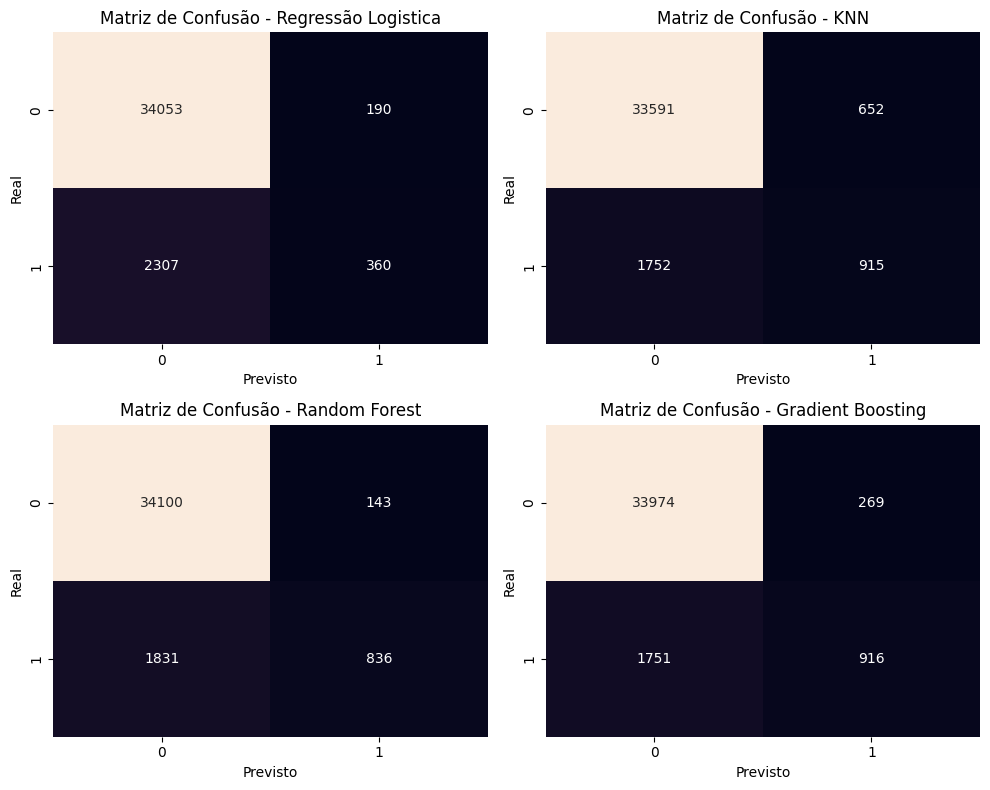

In [19]:
# Lista de nome dos modelos e predições (utilizarei novamente)
model_names = ['Regressão Logistica', 'KNN', 'Random Forest', 'Gradient Boosting']
predictions = [log_predict, knn_predict, random_predict, gb_predict]

# Subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Matrizes de confusão
for i, (model, prediction) in enumerate(zip(model_names, predictions)):
    row = i // 2
    col = i % 2
    cm = confusion_matrix(y_test, prediction)
    sns.heatmap(cm, annot=True, fmt='g', cbar=False, ax=axs[row, col])
    axs[row, col].set_title(f'Matriz de Confusão - {model}')
    axs[row, col].set_xlabel('Previsto')
    axs[row, col].set_ylabel('Real')

# Ajustar layout
plt.tight_layout()
plt.show()

Note que da matriz, já conseguimos identificar a dificuldade de estimar classificação 1.

Da Matriz de Confusão podemos tirar os demais indicadores.

In [20]:
# Regressão Logistica
accuracy_log = accuracy_score(y_test, log_predict)
precision_log = precision_score(y_test, log_predict)
recall_log = recall_score(y_test, log_predict)
f1_log = f1_score(y_test, log_predict)
fpr, tpr, thresholds = roc_curve(y_test, log_predict)
roc_auc_log = auc(fpr, tpr)

# KNN
accuracy_knn = accuracy_score(y_test, knn_predict)
precision_knn = precision_score(y_test, knn_predict)
recall_knn = recall_score(y_test, knn_predict)
f1_knn = f1_score(y_test, knn_predict)
fpr, tpr, thresholds = roc_curve(y_test, knn_predict)
roc_auc_knn =  auc(fpr, tpr)

# Random Forest
accuracy_random = accuracy_score(y_test, random_predict)
precision_random = precision_score(y_test, random_predict)
recall_random = recall_score(y_test, random_predict)
f1_random = f1_score(y_test, random_predict)
fpr, tpr, thresholds = roc_curve(y_test, random_predict)
roc_auc_random = auc(fpr, tpr)

# Gradient Boosting Classifier
accuracy_gb = accuracy_score(y_test, gb_predict)
precision_gb = precision_score(y_test, gb_predict)
recall_gb = recall_score(y_test, gb_predict)
f1_gb = f1_score(y_test, gb_predict)
fpr, tpr, thresholds = roc_curve(y_test, gb_predict)
roc_auc_gb = auc(fpr, tpr)

Agora que os demais metricas de avaliação foram criadas, vamos poder comparar para cada modelo:

In [21]:
# Criando as listas
accuracies = [accuracy_log, accuracy_knn, accuracy_random, accuracy_gb]
precision = [precision_log, precision_knn, precision_random, precision_gb]
recall = [recall_log, recall_knn, recall_random, recall_gb]
f1_scores = [f1_log, f1_knn, f1_random, f1_gb]
roc_aucs = [roc_auc_log, roc_auc_knn, roc_auc_random, roc_auc_gb]

# Arredonda as metricas
accuracies = [round(acc, 2) for acc in accuracies]
precision = [round(prec, 2) for prec in precision]
recall = [round(rec, 2) for rec in recall]
f1_scores = [round(f1, 2) for f1 in f1_scores]
roc_aucs = [round(roc_auc, 2) for roc_auc in roc_aucs]

# Tabela com as metricas dos modelos
df_tabulate = pd.DataFrame({
    'Modelo:': model_names,
    'Acurácia:': accuracies,
    'Precisão:': precision,
    'Recall:': recall,
    'F1-score:': f1_scores,
    'ROC AUC:': roc_aucs})

# Tabulate
print(tabulate(df_tabulate, headers='keys', tablefmt='pretty', showindex=False))

+---------------------+-----------+-----------+---------+-----------+----------+
|       Modelo:       | Acurácia: | Precisão: | Recall: | F1-score: | ROC AUC: |
+---------------------+-----------+-----------+---------+-----------+----------+
| Regressão Logistica |   0.93    |   0.65    |  0.13   |   0.22    |   0.56   |
|         KNN         |   0.93    |   0.58    |  0.34   |   0.43    |   0.66   |
|    Random Forest    |   0.95    |   0.85    |  0.31   |   0.46    |   0.65   |
|  Gradient Boosting  |   0.95    |   0.77    |  0.34   |   0.48    |   0.67   |
+---------------------+-----------+-----------+---------+-----------+----------+


**Resultado dos Modelos**

Notasse que os algoritmos que tiveram a melhor combinação em pares foram os Gradient Boosting com o melhor resultado, seguido do Random Forest, ambos sendo modelos de árvores.

Lembrando que a base é bastante desbalanceada, isso faz com que seja mais facíl prever a categoria majoritária, e por isso elevar os indicadores, portanto, vou seguir dois pontos:



1.   Comparar os resultados com os scores de validação cruzada;
2.   Analisar a densidade das predições.



**Modelos X Validação Cruzada**:



Os valores de score médio (Validação Cruzada) pouco diferem dos resultados apresentados nos modelos previamente criados, com a maior diferença sendo de 0.06 (Gradient Boosting).

Mais uma indicativa de que os modelos não se distanciam muito dos indicadores vistos na base de teste, logo uma boa capacidade de generalização.

**Análise da densidade das predições**

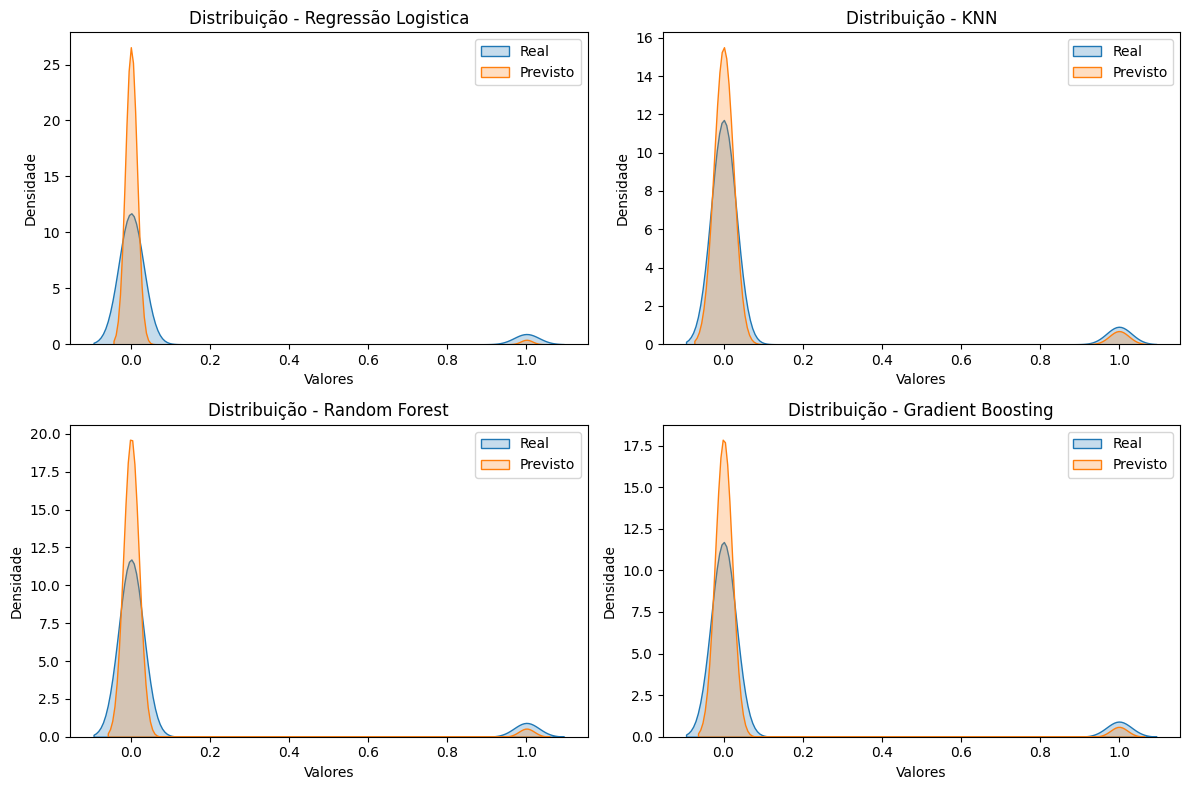

In [22]:
# Subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Gerando gráficos de densidade
for i, (model, prediction) in enumerate(zip(model_names, predictions)):
    row = i // 2
    col = i % 2
    df_density = pd.DataFrame({'Real': y_test, 'Previsto': prediction}, columns=['Real', 'Previsto'])
    sns.kdeplot(df_density['Real'], label='Real', fill=True, ax=axs[row, col])
    sns.kdeplot(df_density['Previsto'], label='Previsto', fill=True, ax=axs[row, col])
    axs[row, col].set_title(f'Distribuição - {model}')
    axs[row, col].set_xlabel('Valores')
    axs[row, col].set_ylabel('Densidade')
    axs[row, col].legend()

# Ajustar layout
plt.tight_layout()
plt.show()

O gráfico de densidade para cada predição consegue mostrar alguns pontos, são eles:

1.    Regressão Logística: Estimou muito mais classificação 0 do que os demais, isso pode ser percebido também pelo valor baixo de recall (0.13).
2.    Todos os modelos estimaram a classificação 0 mais facilmente do que a 1, o que indica um problema de desbalanceamento.

**Qual modelo escolher?**

Nesse atual cenario escolheria o modelo de **Gradient Boosting**, pois como visto nos indicadores F1-Score e ROC AUC, ele foi o melhor em ambos. Já no score da validação cruzada, desvio padrão e densidade ficou com resultados equivalentes com Random Forest.

**Resultado do estudo e objetivos**

Conseguimos alcançar os objetivos do estudo, que eram:

1.    Identificamos as features mais importantes para os eventos e não eventos, permitindo a classificação dos acidentes;
2.    Geramos uma variável de suporte com base estatística.

O desbalanceamento dos dados mostrou que existem pontos que podem ser melhorados. Alguns indicadores, como o valor baixo de Recall em todos os modelos, indicam dificuldade em prever o evento (minoria).

Dado isso, vamos agora trabalhar com dados sintéticos e balanceados.


# Modelos com Oversampling

Nesta sessão vou recriar os modelos que vimos anteriormente, porém, dessa vez será com a base de treino com dados sintéticos. A validação farei encima da base de treino, pois nela não usamos oversampling.

## Select Features

Como nesta sessão iremos trabalhar com dados simulados, é interessante também remover features que tenham alta correlação, assim como feito anteriormente.

**Obs**: Não utilizarei SelectKBest, pois maior número de observações, quero identificar quais as features que mais se destacam.

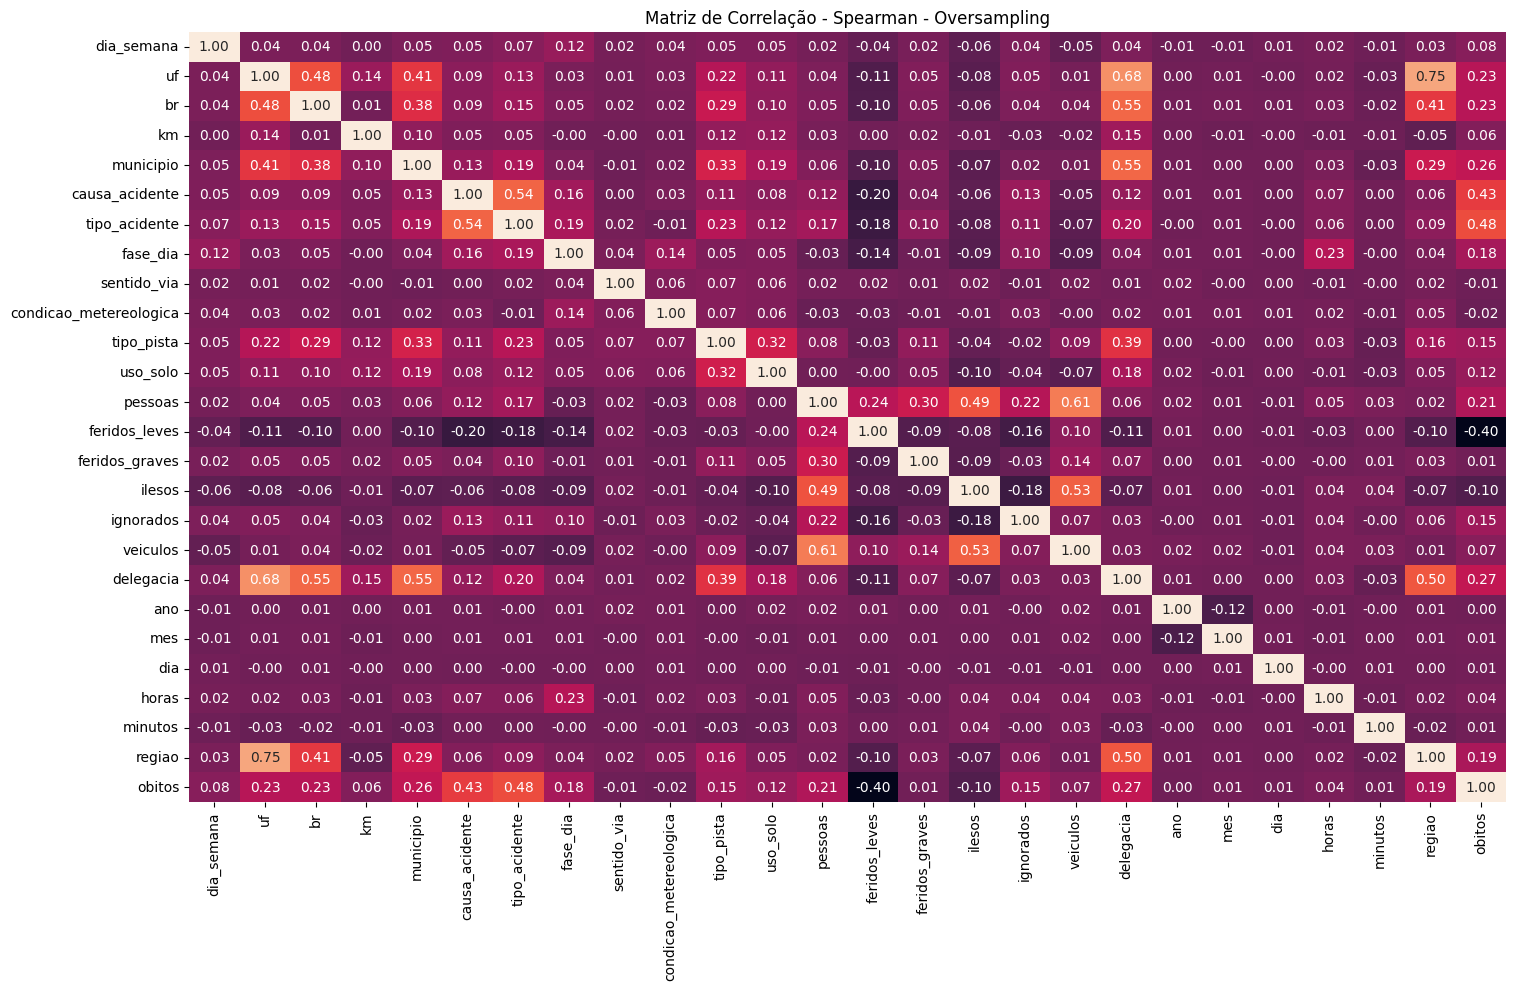

In [23]:
plt.figure(figsize=(17,10))
sns.heatmap(df_train_smote.corr(method = 'spearman') , cbar = False, fmt = '.2f', annot = True)
plt.title('Matriz de Correlação - Spearman - Oversampling')
plt.show()

In [24]:
# Base de treino com dados sintéticos
x_train_smote = df_train_smote.drop(['obitos','uf','delegacia','pessoas'], axis = 1)
y_train_smote = df_train_smote['obitos']

Assim como antes, as features UF e delegacia tiveram maior correlação entre os pares. Pessoas foram removidas conforme explicado inicialmente.

## Regressão Logistica

In [25]:
# Criando o modelo LogisticRegression usando Oversampling
model_log_smt = LogisticRegression(random_state= 1337, max_iter = 1000)
model_log_smt.fit(x_train_smote,y_train_smote)
log_predict_smt = model_log_smt.predict(x_test)

Novamente, adotarei o Logistic Regression como **baseline**.

## KNN

In [26]:
model_knn_smt = KNeighborsClassifier(n_neighbors=5, metric='minkowski')
model_knn_smt.fit(x_train_smote,y_train_smote)
knn_smt_predict = model_knn_smt.predict(x_test)

## Random Forest

In [27]:
# Criando RandomForestClassifier com base de oversampling
model_random_smt = RandomForestClassifier(n_estimators= 150, random_state = 1337)
model_random_smt.fit(x_train_smote,y_train_smote)
random_smt_predict = model_random_smt.predict(x_test)

Variáveis **mais importantes** para o modelo.

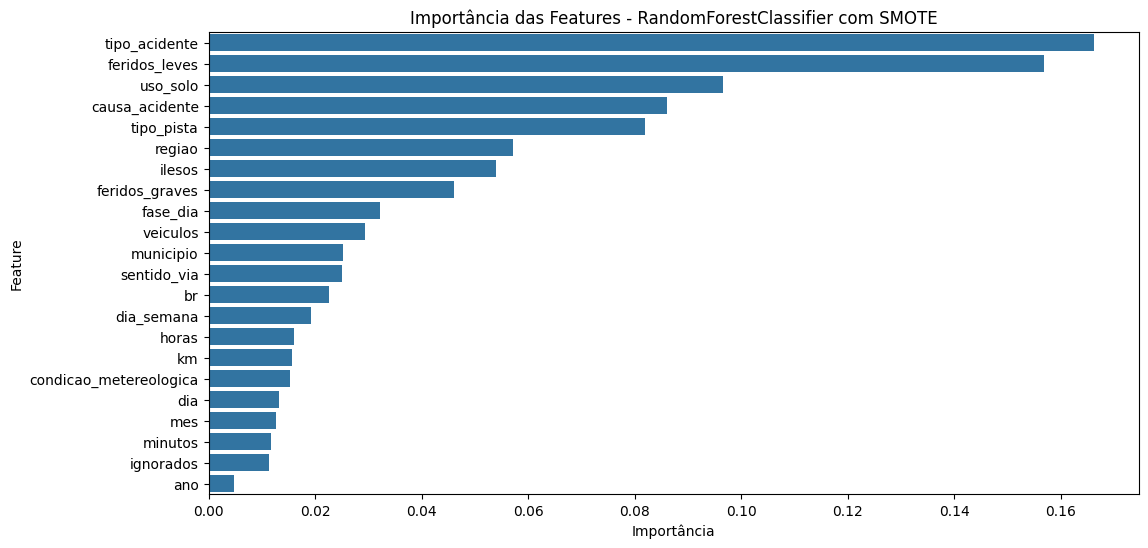

In [28]:
feature_importances = model_random_smt.feature_importances_

# Criando um DataFrame para facilitar a visualização
importances_df = pd.DataFrame({'Feature': x_train.columns, 'Importância': feature_importances})

# Ordenando as features por importância
importances_df = importances_df.sort_values(by='Importância', ascending=False)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Importância', y='Feature', data=importances_df)
plt.title('Importância das Features - RandomForestClassifier com SMOTE')
plt.show()

## Gradient Boosting Classifier

In [29]:
# Criando o modelo GradientBoostingClassifier com a features do Selectkbest
model_gb_smt = GradientBoostingClassifier(n_estimators = 45 , random_state = 1337, max_depth = 5, learning_rate = 0.1)
model_gb_smt.fit(x_train_smote, y_train_smote)
gb_smt_predict= model_gb_smt.predict(x_test)

Reduzi os parametros, visto que agora temos uma base equilibrada.

Features mais importantes para o Gradient Boosting

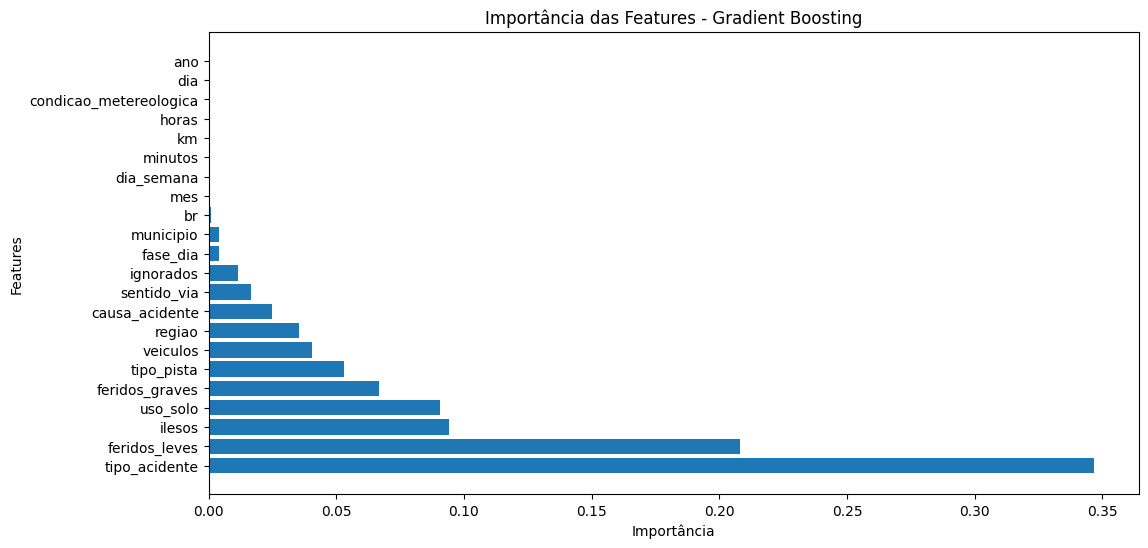

In [30]:
# Feature + relevantes
feature_importances_gb = model_gb_smt.feature_importances_
sorted_indices_gb = np.argsort(feature_importances_gb)[::-1]

# Ordenando por importancia
sorted_feature_names_gb = [x_train.columns[i] for i in sorted_indices_gb]
sorted_importances_gb = [feature_importances_gb[i] for i in sorted_indices_gb]

# Plot
plt.figure(figsize=(12, 6))
plt.barh(sorted_feature_names_gb, sorted_importances_gb)
plt.title('Importância das Features - Gradient Boosting')
plt.xlabel('Importância')
plt.ylabel('Features')
plt.show()

## Resultado dos Modelos com Oversampling

Vamos recriar os modelos em um nova base, que possui dados sintéticos e avaliar seu desempenho.

**Matriz de Confusão (Oversampling)**

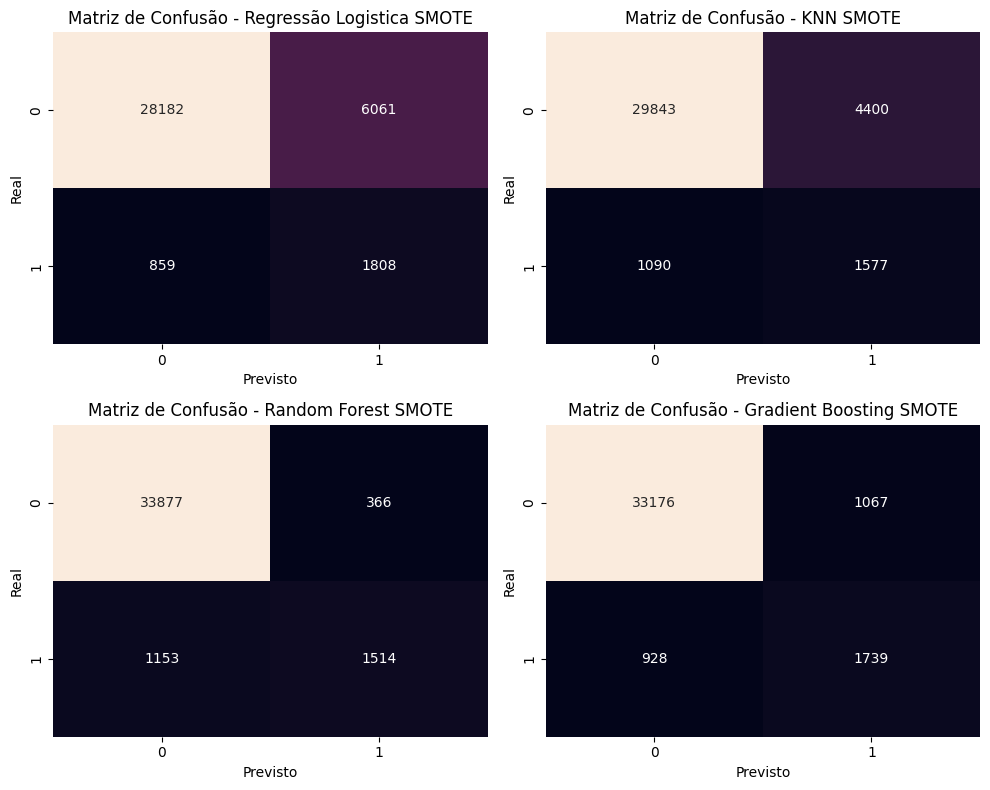

In [31]:
# Lista de nome dos modelos e predições que foram usados em Oversampling
model_names_smote = ['Regressão Logistica SMOTE', 'KNN SMOTE', 'Random Forest SMOTE', 'Gradient Boosting SMOTE'] # Como SMOTE foi atecnica usada, deixarei na nomenclatura
predictions_smote = [log_predict_smt, knn_smt_predict, random_smt_predict, gb_smt_predict]

# Subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Matrizes de confusão
for i, (model, prediction) in enumerate(zip(model_names_smote, predictions_smote)):
    row = i // 2
    col = i % 2
    cm = confusion_matrix(y_test, prediction)
    sns.heatmap(cm, annot=True, fmt='g', cbar=False, ax=axs[row, col])
    axs[row, col].set_title(f'Matriz de Confusão - {model}')
    axs[row, col].set_xlabel('Previsto')
    axs[row, col].set_ylabel('Real')

plt.tight_layout()
plt.show() # Manterei o formato para auxiliar na comparação

Agora vamos gerar os indicadores para os modelos com dados sinteticos.

In [32]:
# Regressão Logistica - SMOTE
accuracy_log_smt = accuracy_score(y_test, log_predict_smt)
precision_log_smt = precision_score(y_test, log_predict_smt)
recall_log_smt = recall_score(y_test, log_predict_smt)
f1_log_smt = f1_score(y_test, log_predict_smt)
fpr, tpr, thresholds = roc_curve(y_test, log_predict_smt)
roc_auc_log_smt = auc(fpr, tpr)

# KNN - SMOTE
accuracy_knn_smt = accuracy_score(y_test, knn_smt_predict)
precision_knn_smt = precision_score(y_test, knn_smt_predict)
recall_knn_smt = recall_score(y_test, knn_smt_predict)
f1_knn_smt = f1_score(y_test, knn_smt_predict)
fpr, tpr, thresholds = roc_curve(y_test, knn_smt_predict)
roc_auc_knn_smt = auc(fpr, tpr)

# Random Forest - SMOTE
accuracy_random_smt = accuracy_score(y_test, random_smt_predict)
precision_random_smt = precision_score(y_test, random_smt_predict)
recall_random_smt = recall_score(y_test, random_smt_predict)
f1_random_smt = f1_score(y_test, random_smt_predict)
fpr, tpr, thresholds = roc_curve(y_test, random_smt_predict)
roc_auc_random_smt = auc(fpr, tpr)

# Gradient Boosting Classifier - SMOTE
accuracy_gb_smt = accuracy_score(y_test, gb_smt_predict)
precision_gb_smt  = precision_score(y_test, gb_smt_predict)
recall_gb_smt = recall_score(y_test, gb_smt_predict)
f1_gb_smt = f1_score(y_test, gb_smt_predict)
fpr, tpr, thresholds = roc_curve(y_test, gb_smt_predict)
roc_auc_gb_smt = auc(fpr, tpr)

Vamos comparar os modelos criados com dados sintéticos.

In [33]:
# Criando as listas
accuracies_smt = [accuracy_log_smt, accuracy_knn_smt, accuracy_random_smt, accuracy_gb_smt]
precision_smt = [precision_log_smt, precision_knn_smt, precision_random_smt, precision_gb_smt]
recall_smt = [recall_log_smt, recall_knn_smt, recall_random_smt, recall_gb_smt]
f1_scores_smt = [f1_log_smt, f1_knn_smt, f1_random_smt, f1_gb_smt]
roc_aucs_smt = [roc_auc_log_smt, roc_auc_knn_smt, roc_auc_random_smt, roc_auc_gb_smt]

# Arredonda as metricas
accuracies_smt = [round(acc, 2) for acc in accuracies_smt]
precision_smt = [round(prec, 2) for prec in precision_smt]
recall_smt = [round(rec, 2) for rec in recall_smt]
f1_scores_smt = [round(f1, 2) for f1 in f1_scores_smt]
roc_aucs_smt = [round(roc_auc, 2) for roc_auc in roc_aucs_smt]

# Tabela com as metricas dos modelos
df_tabulate_smt = pd.DataFrame({
    'Modelo:': model_names,
    'Acurácia:': accuracies_smt,
    'Precisão:': precision_smt,
    'Recall:': recall_smt,
    'F1-score:': f1_scores_smt,
    'ROC AUC:': roc_aucs_smt})

# Tabulate
print(tabulate(df_tabulate_smt, headers='keys', tablefmt='pretty', showindex=False))

+---------------------+-----------+-----------+---------+-----------+----------+
|       Modelo:       | Acurácia: | Precisão: | Recall: | F1-score: | ROC AUC: |
+---------------------+-----------+-----------+---------+-----------+----------+
| Regressão Logistica |   0.81    |   0.23    |  0.68   |   0.34    |   0.75   |
|         KNN         |   0.85    |   0.26    |  0.59   |   0.36    |   0.73   |
|    Random Forest    |   0.96    |   0.81    |  0.57   |   0.67    |   0.78   |
|  Gradient Boosting  |   0.95    |   0.62    |  0.65   |   0.64    |   0.81   |
+---------------------+-----------+-----------+---------+-----------+----------+


Os modelos Random Forest e Gradient Boosting, possuem a mesma média de F1-Score e ROC AUC, ambas são 0.725, podesse **escolher qualquer um desses dois modelos**.

**Porém**, vamos verificar a densidade das predições.

**Densidade das predições**

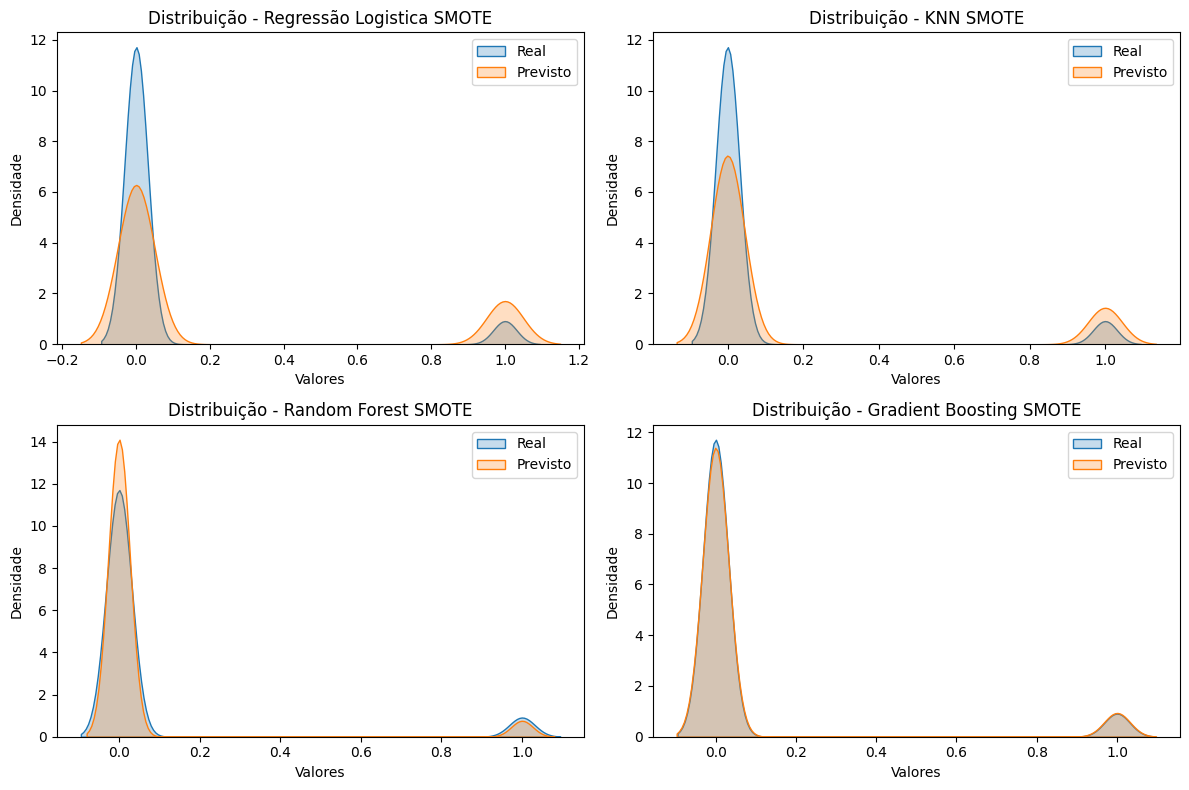

In [34]:
# Subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Gerando gráficos de densidade
for i, (model, prediction) in enumerate(zip(model_names_smote, predictions_smote)):
    row = i // 2
    col = i % 2
    df_density = pd.DataFrame({'Real': y_test, 'Previsto': prediction}, columns=['Real', 'Previsto'])
    sns.kdeplot(df_density['Real'], label='Real', fill=True, ax=axs[row, col])
    sns.kdeplot(df_density['Previsto'], label='Previsto', fill=True, ax=axs[row, col])
    axs[row, col].set_title(f'Distribuição - {model}')
    axs[row, col].set_xlabel('Valores')
    axs[row, col].set_ylabel('Densidade')
    axs[row, col].legend()

plt.tight_layout()

plt.show()

**Insights**:



1.   Os modelos de Regressão Logistica e KNN tiveram mais dificuldade em estimar a classificação 1 e estimaram demais a 0;
2.   Modelos de árvores tiveram desnsidades mais proximas das reais;
3.   Gradient Boosting foi o algoritmo que teve suas predições mais proximas das reais.



**Qual modelo escolher?**

Escolheria o **Random Forest**, pois possui a mesma média nos indicadores F1-Score e ROC AUC, uma diferença de 0.03 pontos para cada, em comparação com o Gradient Boosting.

O fator decisivo é a densidade das predições; modelos com densidade "quase coladas" mostram uma similaridade alta entre valores previstos e reais, indicativo que me preocupa em relação a ocorrer sobreajuste.

**Resultado do estudo e objetivos**


Novamente, conseguimos alcançar os objetivos do estudo. Identificamos as variáveis mais importantes e também criamos uma variável que estima a probabilidade do acidente resultar em vítimas fatais.

Conseguimos também aprimorar os indicadores, principalmente o Recall, F1-score e ROC AUC. Além disso, exploramos mais os algoritmos de classificação.